In [1]:
# Import libraries
import os
import sys
sys.path.append('../')
os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=4 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=6
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=4
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=6
import matplotlib.pyplot as plt
from pylab import rcParams
import pandas as pd
import warnings
from econml.sklearn_extensions.linear_model import WeightedLassoCV
import sklearn.model_selection as sms
import sklearn.linear_model as slm
import sklearn.preprocessing as skp
import sklearn.metrics as sme
import sklearn.feature_selection as skf
import sklearn.ensemble as ske
import sklearn.utils as sku
import sklearn.decomposition as skd
import sklearn.neural_network as skn
from celer import GroupLassoCV
from sklearnex import patch_sklearn, config_context
from sklearn.cluster import DBSCAN
import numpy as np
import scipy.stats as stats
from IPython.display import HTML
import util as util
from scipy.spatial import cKDTree
import nibabel as nib
import os
import pickle
from torch import nn
from sklearn.exceptions import ConvergenceWarning
import seaborn as sns
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
HTML('''
<style>
.jupyter-matplotlib {
    background-color: #000;
}

.widget-label, .jupyter-matplotlib-header{
    color: #fff;
}

.jupyter-button {
    background-color: #333;
    color: #fff;
}
</style>
''')

In [3]:
cv_names = {'CORNELL ID',
            ' OFF (pre-dbs updrs)',
            ' ON (pre-dbs updrs)',
            ' OFF meds ON stim 6mo',
            'Age',
            'Sex',
            'Ethnicity',
            'Race',
            'Disease Duration (year)',
            'Physician',
            ' pre op levadopa equivalent dose (mg)',
            ' Location',
            ' Target',
            ' Test medication status',
}

In [4]:
# Get case IDs
case_list = open('/home/ali/RadDBS-QSM/data/docs/cases_90','r')
lines = case_list.read()
lists = np.loadtxt(case_list.name,comments="#", delimiter=",",unpack=False,dtype=str)
case_id = []
for lines in lists:     
    case_id.append(lines[-9:-7])

# Load scores
file_dir = '/home/ali/RadDBS-QSM/data/docs/dbs_03292024.csv'
motor_df = util.filter_data(file_dir,cv_names)
# Find cases with all required scores
cv_dict = util.filter_cases(motor_df,cv_names)
subs = cv_dict['CORNELL ID']
# Load extracted features
npy_dir = '/home/ali/RadDBS-QSM/data/npy/'
phi_dir = '/home/ali/RadDBS-QSM/data/phi/phi/'
roi_path = '/data/Ali/atlas/mcgill_pd_atlas/PD25-subcortical-labels.csv'
n_rois = 6
all_rois = False
Phi_all, X_all, R_all, K_all, ID_all = util.load_featstruct(phi_dir,npy_dir+'X/',npy_dir+'R/',npy_dir+'K/',n_rois,1595,all_rois)
ids = np.asarray(ID_all).astype(int)

# Find overlap between scored subjects and feature extraction cases
c_cases = np.intersect1d(np.asarray(case_id).astype(int),np.asarray(cv_dict['CORNELL ID']).astype(int))
# Complete case indices with respect to feature matrix
c_cases_idx = np.in1d(ids,c_cases)
X_all_c = X_all[c_cases_idx,:,:]
K_all_c = K_all[c_cases_idx,:,:]
R_all_c = R_all[c_cases_idx,:,:]
# Re-index the scored subjects with respect to complete cases
s_cases_idx = np.in1d(subs,ids[c_cases_idx])
subsc = subs[s_cases_idx]
per_change = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' OFF meds ON stim 6mo'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
pre_imp = ((cv_dict[' OFF (pre-dbs updrs)']-cv_dict[' ON (pre-dbs updrs)'])/cv_dict[' OFF (pre-dbs updrs)'])[s_cases_idx]
# Reshape keys and ROIs
if all_rois == True:
    K_all_cu = np.empty((K_all_c.shape[0],K_all_c.shape[1],K_all_c.shape[2]+1),dtype=object)
    K_all_cu[:,:,:-1] = K_all_c
    K_all_cu[:,:,-1] = 'pre_updrs'
    K = K_all_cu.reshape((K_all_cu.shape[0],K_all_cu.shape[1]*K_all_cu.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))
else:
    K = K_all_c.reshape((K_all_c.shape[0],K_all_c.shape[1]*K_all_c.shape[2]))[0]
    R = R_all_c.reshape((R_all_c.shape[0],R_all_c.shape[1]*R_all_c.shape[2]))


Keeping CORNELL ID
Keeping Age
Keeping Sex
Keeping Ethnicity
Keeping Race
Keeping Disease Duration (year)
Keeping Physician
Keeping  OFF (pre-dbs updrs)
Keeping  ON (pre-dbs updrs)
Keeping  pre op levadopa equivalent dose (mg)
Keeping  Location
Keeping  Target
Keeping  Test medication status
Keeping  OFF meds ON stim 6mo
{' Target', 'CORNELL ID', ' OFF (pre-dbs updrs)', ' Test medication status', ' pre op levadopa equivalent dose (mg)', 'Race', 'Sex', 'Physician', 'Disease Duration (year)', ' ON (pre-dbs updrs)', ' Location', ' OFF meds ON stim 6mo', 'Ethnicity', 'Age'}
Allocated arrays
Created feature matrix
Created ROI matrix
Created feature label matrix


In [5]:
scoring = 'r2'
results_bls = np.zeros_like(per_change)
results_ls = np.zeros_like(per_change)
results_gls = np.zeros_like(per_change)
gerror = np.zeros_like(per_change)
r = np.zeros_like(per_change)
rerror = np.zeros_like(per_change)
err_var = np.zeros_like(per_change)
alphas = np.logspace(-4,4,100)
Ks = []
Kstg = []
w = []
wg = []
pcases = []
pscores = []
s = []

In [6]:
X = X_all_c.reshape(X_all_c.shape[0],-1)
R = R[0].tolist()
for cv_name in cv_names:
    if cv_name != ' OFF meds ON stim 6mo' and cv_name != 'CORNELL ID':
        print('Appending',cv_name)
        X = np.append(X,cv_dict[cv_name][s_cases_idx].reshape(-1,1),axis=1)
        K = np.append(K,[cv_name],axis=0)
        R.append('Clinical')
scaler = skp.StandardScaler()
X0_ss0 = scaler.fit_transform(X)

Appending  Target
Appending  OFF (pre-dbs updrs)
Appending  Test medication status
Appending  pre op levadopa equivalent dose (mg)
Appending Race
Appending Sex
Appending Physician
Appending Disease Duration (year)
Appending  ON (pre-dbs updrs)
Appending  Location
Appending Ethnicity
Appending Age


original_firstorder_Kurtosis 0.368 0.01649
exponential_firstorder_Kurtosis 0.397 0.00923
wavelet-LLL_firstorder_Kurtosis 0.375 0.01444
original_shape_Elongation 0.373 0.01492
original_shape_MeshVolume -0.366 0.01707
original_shape_SurfaceArea -0.395 0.00965
original_shape_VoxelVolume -0.366 0.01717
original_glrlm_GrayLevelNonUnifo -0.362 0.01844
exponential_gldm_GrayLevelNonUni -0.38 0.01304
exponential_glrlm_GrayLevelNonUn -0.419 0.00579
exponential_glszm_LargeAreaEmpha -0.424 0.00511
exponential_glszm_LargeAreaHighG -0.424 0.00511
exponential_glszm_LargeAreaLowGr -0.424 0.00511
gradient_ngtdm_Coarseness 0.379 0.01341
lbp-3D-m1_firstorder_Energy -0.389 0.01083
lbp-3D-m1_firstorder_TotalEnergy -0.389 0.01083
lbp-3D-m1_gldm_GrayLevelNonUnifo -0.366 0.01717
lbp-3D-m1_glrlm_GrayLevelNonUnif -0.413 0.00653
lbp-3D-m1_glrlm_RunLengthNonUnif -0.422 0.00541
lbp-3D-m1_glszm_LargeAreaEmphasi -0.375 0.01447
lbp-3D-m1_glszm_LargeAreaHighGra -0.375 0.01447
lbp-3D-m1_glszm_LargeAreaLowGray -0.375 0.

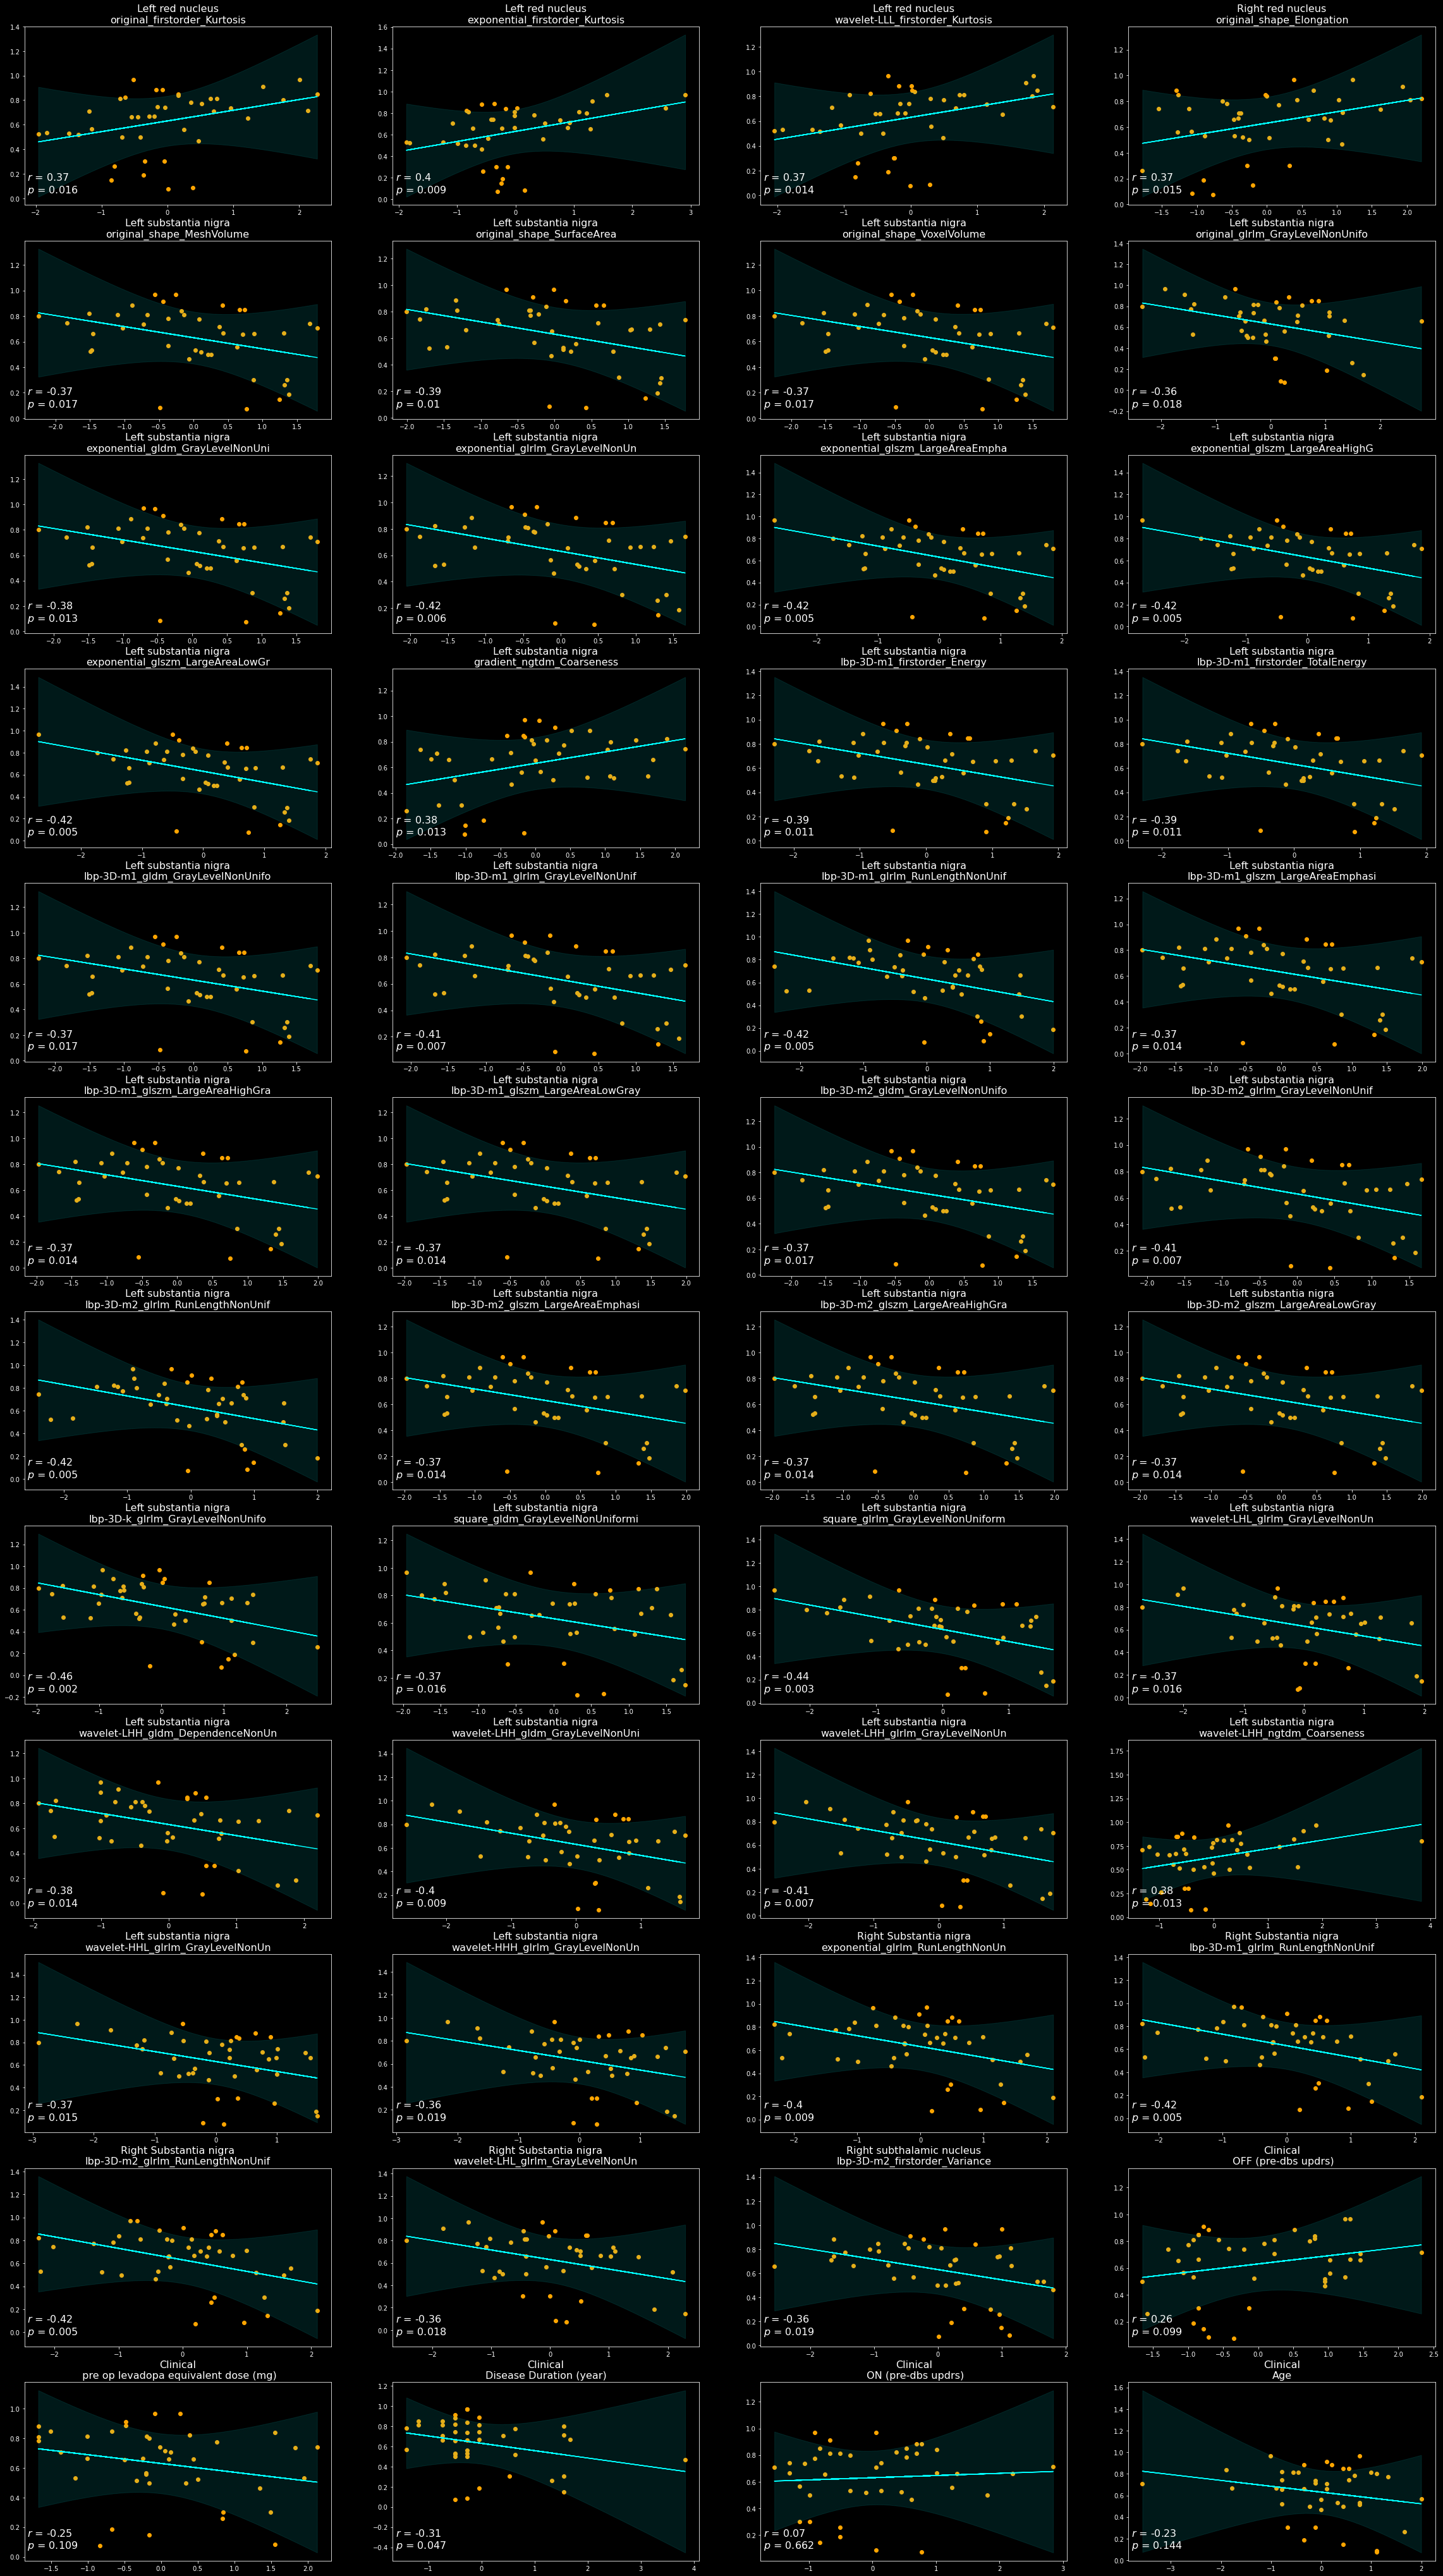

In [33]:
rcParams['figure.figsize'] = 40, 80
pc = 0
v = 0
nps = 52
rw = 13
viz = True
with warnings.catch_warnings() and np.errstate(divide='ignore', invalid='ignore'):
  # Feature selection
    for k in np.arange(X0_ss0.shape[1]):
      #if pc < nps:
        lr = stats.linregress(X0_ss0[:,k],per_change)
        if (abs(lr.rvalue)>0.35 and lr.pvalue < 0.02) or (R[k]=='Clinical' and len(np.unique(X0_ss0[:,k])) > 7):
          print(K[k],np.round(lr.rvalue,3),np.round(lr.pvalue,5))
          y_model = X0_ss0[:,k]*lr.slope+lr.intercept
          if viz == True:
            v = v+1
            ax = plt.subplot(rw,nps//rw,v)
            ax.scatter(X0_ss0[:,k],per_change,color='orange')
            ax.plot(X0_ss0[:,k],y_model,color='cyan') 

          x = X0_ss0[:,k]
          y = results_ls
          x_mean = np.mean(x)
          y_mean = np.mean(y)
          # number of samples
          n = x.size   
          # number of parameters: slope and intercept                     
          m = 2     
          # degrees of freedom                       
          dof = n-m  
          # statistic of interval confidence                       
          t = stats.t.ppf(0.975,dof)  
          # Standard deviation of the error
          residual_ut = y-y_model
          std_error = (np.sum(residual_ut**2)/dof)**(1/2)

          # Pearson's correlation coefficient
          numerator = np.sum((x-x_mean)*(y-y_mean))
          denominator = (np.sum((x-x_mean)**2)*np.sum((y-y_mean)**2))**(1/2)
          correlation_coef = numerator/denominator
          r = correlation_coef
          tr = r*np.sqrt(n-2)/(np.sqrt(1-r**2))
          # p-value for 2-sided test
          pv = 2*(1-stats.t.cdf(abs(tr), dof))
          # mean squared error
          MSE = 1/n*np.sum((y-y_model)**2)
      
      
          x_line = np.linspace(np.min(x),np.max(x),len(x))
          y_line = x_line*lr.slope+lr.intercept
          ci = t*std_error*(1/n+(x_line-x_mean)**2/np.sum((x-x_mean)**2))**(1/2)
          ax.set_title(R[k]+'\n'+K[k],fontsize=16)
          ax.fill_between(x_line,y_line+ci,y_line-ci,color = 'cyan',label = '95% confidence interval',alpha=0.1)
          ax.text(0.01,0.05,'$r$ = '+str(np.round(lr.rvalue,2))+'\n'+'$p$ = '+str(round(lr.pvalue,3)),
                  ha='left', va='bottom', transform=ax.transAxes,fontsize=16)   
          plt.style.use('dark_background')
          pc = pc+1


  

   
